<a href="https://colab.research.google.com/github/Evans-tats/CodeAlpha_Emotion-Recognition-from-Speech/blob/main/Emotion_Recognition_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import os

In [2]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evanskipsang","key":"ff66d8f0e99e93411cd7356a4a979f33"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 407M/429M [00:03<00:00, 134MB/s]
100% 429M/429M [00:03<00:00, 141MB/s]


In [6]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess_data


Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess_data/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess_data/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess_data

In [7]:
import os

file_emotion = []
file_path = []

data_dir = './ravdess_data/'
data = os.listdir(data_dir)

for i in data:
    actor_dir = os.path.join(data_dir, i)

    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)

        for f in actor_files:
            if f.endswith('.wav'):
                part = f.split('.')[0].split('-')

                if len(part) >= 3:
                    try:
                        emotion_code = int(part[2])
                        file_emotion.append(emotion_code)
                        file_path.append(os.path.join(actor_dir, f))
                    except ValueError:
                        print(f"Skipping file with invalid emotion code: {f}")
                else:
                    print(f"Skipping malformed filename: {f}")


In [8]:
print(file_emotion[0])

8


In [10]:
emotion_map = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

emotion_labels = [emotion_map[e] for e in file_emotion]

In [11]:
emotion_labels[300]

'disgust'

In [13]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

In [14]:
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(Ravdess_df.head())
print("______________________________________________")
print(Ravdess_df.tail())
print("_______________________________________________")
print(Ravdess_df.Emotions.value_counts())

   Emotions                                              Path
0  surprise  ./ravdess_data/Actor_06/03-01-08-01-01-01-06.wav
1   neutral  ./ravdess_data/Actor_06/03-01-02-02-02-02-06.wav
2  surprise  ./ravdess_data/Actor_06/03-01-08-01-01-02-06.wav
3   neutral  ./ravdess_data/Actor_06/03-01-02-01-01-01-06.wav
4   neutral  ./ravdess_data/Actor_06/03-01-01-01-01-01-06.wav
______________________________________________
     Emotions                                              Path
1435  neutral  ./ravdess_data/Actor_04/03-01-01-01-02-01-04.wav
1436  neutral  ./ravdess_data/Actor_04/03-01-02-02-01-01-04.wav
1437    angry  ./ravdess_data/Actor_04/03-01-05-02-01-02-04.wav
1438     fear  ./ravdess_data/Actor_04/03-01-06-02-02-02-04.wav
1439  disgust  ./ravdess_data/Actor_04/03-01-07-02-02-02-04.wav
_______________________________________________
Emotions
neutral     288
surprise    192
fear        192
sad         192
disgust     192
happy       192
angry       192
Name: count, dtype: int64


/tmp/ipython-input-14-799736559.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [19]:
data ,sr = librosa.load(file_path[0])
sr

22050

In [20]:
ipd.Audio(data,rate=sr)

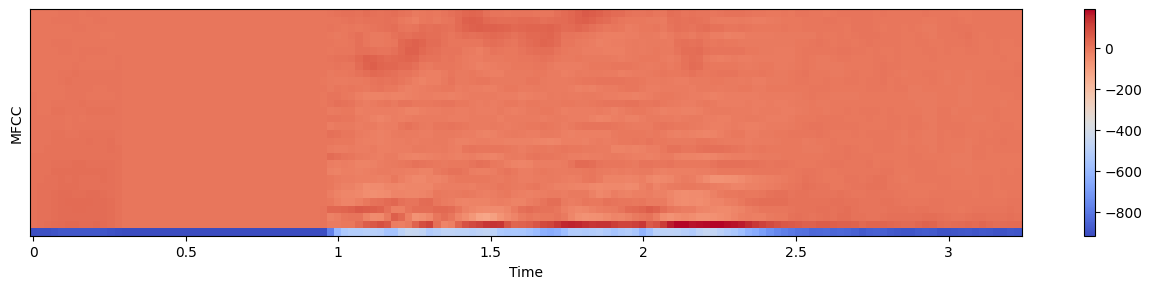

In [24]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)